<h3>Wishbone for single cell RNA-seq</h3>

<h4>Table of contents</h4>
<br/>
<a href='#intro'>Introduction</a>
<br/>
<a href='#data'>Loading data</a>
<br/>
<a href='#pre'>Data preprocessing</a>
<br/>
<a href='#wishbone'>Running Wishbone</a>
<br/>
<a href='#wishbone2'>Visualizing Wishbone results</a>

<a id="intro"></a><h3> Introduction </h3>

Wishbone is an algorithm to identify bifurcating developmental trajectories from single cell data. Wishbone can applied to both single cell RNA-seq and mass cytometry datasets. This notebook details the usage of Wishbone for single cell RNA-seq data.

<a id="data"></a><h3> Loading data </h3>

Wishbone can read single cell RNA-seq data from a csv file. The csv file contains cells in the rows and genes in the columns. First step is to import the package. The following code snipped imports the `wishbone` package along with other plotting related imports

In [1]:
import wishbone

# Plotting and miscellaneous imports
import os
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

A sample RNA-seq csv data is installed at `~/.wishbone/data/sample_scseq_data.csv`. This sample data will be used to demonstrate the utilization and capabilities of the Wishbone package. This is a sample data derived from <a href="https://www.ncbi.nlm.nih.gov/pubmed/26627738">Paul et. al.</a> and represents the differentiation of myeloid and erythroid precursors from hematopoietic stem cells in the mouse bone marrow<br/>
The data can be loaded using the `wishbone.wb.SCData.from_csv` function. 

In [2]:
# Load sample data
scdata = wishbone.wb.SCData.from_csv(os.path.expanduser('~/.wishbone/data/sample_scseq_data.csv'), 
                data_type='sc-seq', normalize=True)

This will create an object of the type `wishbone.wb.SCData` which is the base class for the analysis. This can be either be single cell RNA-seq or mass cytometry and is specified by using `data_type` parameter set to `sc-seq` or `masscyt` respectively. The `normalize` parameter is used for correcting for library size among cells.

<a id='pca'></a>A summary of the `scdata` object is shown below

In [3]:
scdata

SCData: 4423 cells x 2312 genes

cluster_assignments=None
data_type=True
diffusion_eigenvalues=None
diffusion_eigenvectors=None
diffusion_map_correlations=None
library_sizes=True
metadata=True
normalized=True
pca=None
reads=True
tsne=None

This shows that the data matrix contains `4423` cells and `2312` genes along with the different properties of the `wishbone.wb.SCData` class.

The `scdata` object can also be initialized using a `pandas DataFrame`. An example is shown below <br/>
<code>
scdata = wishbone.wb.SCData(data_frame, 'sc-seq')
scdata = scdata = scdata.normalize_scseq_data()
</code>

<a id='pre'></a><h3>Data preprocessing</h3>

<h4> Principal component analysis </h4>

The first step in data processing for Wishbone is to determine metagenes using principal component analysis. This representation is necessary to overcome the extensive dropouts that are pervasive in single cell RNA-seq data

In [4]:
scdata.run_pca()

Each of the analysis function updates the `scdata` object. As shown below, the `pca` property of the `scdata` object is now changed to `True` compared to <a href="#pca">`False`</a> when the object was created

In [5]:
scdata

SCData: 4423 cells x 2312 genes

cluster_assignments=None
data_type=True
diffusion_eigenvalues=None
diffusion_eigenvectors=None
diffusion_map_correlations=None
library_sizes=True
metadata=True
normalized=True
pca=True
reads=True
tsne=None

The results of PCA i.e., the fraction of variance explained by each component can be visualized using the function `plot_pca_variance_explained`. Use the `ylim` and `n_components` parameters to set the y-axis limits and visualize variance explained by `n_components` respectively. Typically, most of the variance is explained by the first few components (No more than 15).

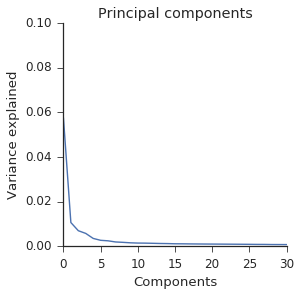

In [6]:
fig, ax = scdata.plot_pca_variance_explained(ylim=(0, 0.1), n_components=30)

From this, choose the appropriate number of components using the elbow method. While `tSNE` visualization is sensitive to the number of components chosen, downstream results are robust to this parameter. 

<h4> tSNE visualization </h4>

Wishbone uses tSNE for visualization and tSNE can be run using the `run_tsne` function which takes the number of principal components as the parameter. From the above plot, 5 seems an appropriate number of components to use.

In [7]:
NO_CMPNTS = 5
scdata.run_tsne(n_components=NO_CMPNTS, perplexity=30)

If running in notebook, please look at the command line window for tSNE progress log


`perplexity` by default is set 30. This will be reduced automatically to 15 is the number of cells is less than 100. 

tSNE results can be visualized by the `plot_tsne` and `plot_tsne_by_cell_sizes` functions. The `plot_tsne_by_cell_sizes` function colors the cells by their molecule counts before normalization

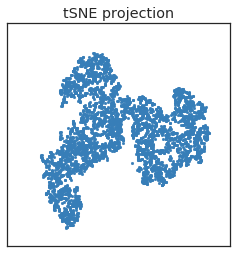

In [8]:
fig, ax = scdata.plot_tsne()

(<matplotlib.figure.Figure at 0x1104b6f60>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1107340b8>)

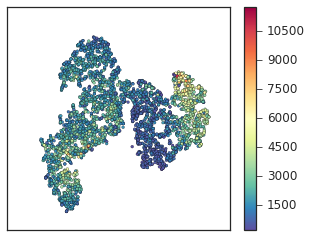

In [9]:
fig = plt.figure(figsize=[5, 4])
scdata.plot_tsne_by_cell_sizes(fig=fig)

Gene expression can be visualized on tSNE maps using the `plot_gene_expression` function. The `genes` parameter is an string iterable of genes, which are a subset of the expression of column names. The below function plots the expression of HSC gene `CD34`, myeloid gene `MPO` and erythroid precursor genes `GATA2` and `GATA1`. 

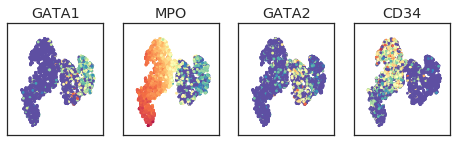

In [10]:
fig, ax = scdata.plot_gene_expression(genes = ['CD34', 'GATA2', 'GATA1', 'MPO'])

<h4> Diffusion maps </h4>

Wishbone uses diffusion maps, a non-linear dimensionality reduction technique to denoise the data and capture the major axes of variation. Diffusion maps can be determined by using the `run_diffusion_map` function and the diffusion components visualized on tSNE maps using `plot_diffusion_components`.

In [11]:
# Run diffusion maps
scdata.run_diffusion_map()

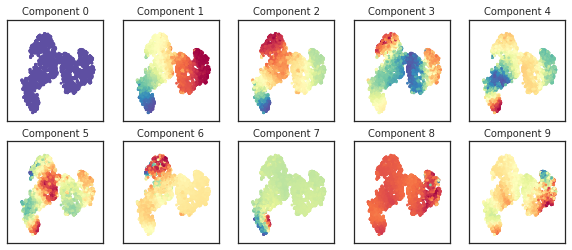

In [12]:
fig, ax = scdata.plot_diffusion_components()

Note the component 0 is the trivial component and does not encode any information of the data

Unlike mass cytometry data, the differentiation signals in single cell RNA-seq data by virtue of measuring the transcriptome are confounded by biological processes such as stress, cell cycle and metabolism. Since diffusion components, capture the major axes of variation, Wishbone uses <a href="http://software.broadinstitute.org/gsea/index.jsp">gene set enrichment analysis</a> among of genes along the top diffusion components to remove components that encode confounding signals. The relevant signals are usually present in the top 2-3 diffusion components <br/>

The first step in computing these enrichments is to determine the correlation of gene expression along each component to derive a ranking of genes along each component.

In [13]:
scdata.run_diffusion_map_correlations()

The function `plot_gene_component_correlations` shows the distribution of correlations along each component.

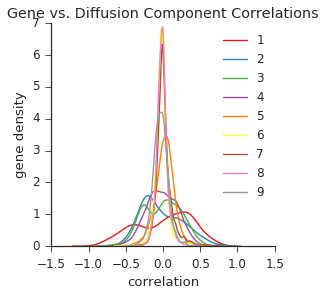

In [14]:
fig, ax = scdata.plot_gene_component_correlations()

The enrichments can be determined using the `run_gsea` function. This function needs the prefix for generating GSEA reports and a `gmt` file representing the different gene sets. The following invocation of the function shows the supported set of `gmt` files

<b>Note: </b> The gmt files package with Wishbone assume all the gene names to be upper case. This can be ensured using the following code snipped.

In [15]:
scdata.data.columns = scdata.data.columns.str.upper()

In [16]:
scdata.run_gsea( output_stem= os.path.expanduser('~/.wishbone/gsea/mouse_marrow'))

Available GSEA .gmt files:

mouse:
gofat.bp.v1.0.gmt.txt
gofat.cc.v1.0.gmt.txt
gofat.mf.v1.0.gmt.txt

human:
c1.all.v5.0.symbols.gmt.txt
c2.all.v5.0.symbols.gmt.txt
c3.all.v5.0.symbols.gmt.txt
c5.all.v5.0.symbols.gmt.txt
c6.all.v5.0.symbols.gmt.txt
c7.all.v5.0.symbols.gmt.txt
gofat.bp.v1.0.gmt.txt
gofat.cc.v1.0.gmt.txt
gofat.mf.v1.0.gmt.txt
h.all.v5.0.symbols.gmt.txt

Please specify the gmt_file parameter as gmt_file=(organism, filename)


Since this is data from mouse, `gmt_file` parameter can be set to `(mouse, gofat.bp.v1.0.gmt.txt)`

In [17]:
reports = scdata.run_gsea(output_stem= os.path.expanduser('~/.wishbone/gsea/mouse_marrow'), 
                    gmt_file=('mouse', 'gofat.bp.v1.0.gmt.txt'))

If running in notebook, please look at the command line window for GSEA progress log


The detailed reports can be found at `~/.wishbone/gsea/`

In [18]:
!open ~/.wishbone/gsea/

`run_gsea` function also returns the top enrichment gene sets along each component. GSEA determines enrichments that are either positively or negatively correlated with the gene component correlations. In this datasets, components 1 and 2 show relevant enrichments and are used for running Wishbone. Please see `Selection of diffusion components for single cell RNA-seq` section of the Supplementary Methods for more details.

In [19]:
# Component 1 enrichments
reports[1]['neg']

NAME
GO_0006952|DEFENSE RESPONSE        0.000000
GO_0006955|IMMUNE RESPONSE         0.000000
GO_0009611|RESPONSE TO WOUNDING    0.008667
GO_0007610|BEHAVIOR                0.020519
GO_0045321|LEUKOCYTE ACTIVATION    0.096134
Name: FDR q-val, dtype: float64

In [20]:
# Component 2 enrichments
reports[2]['pos']

NAME
GO_0006955|IMMUNE RESPONSE         0.000000
GO_0045321|LEUKOCYTE ACTIVATION    0.009399
GO_0001775|CELL ACTIVATION         0.014195
Name: FDR q-val, dtype: float64

<h4> Saving SCData object </h4>

The `SCData` object can be saved to a pickle file and loaded using the `save` and `load` functions.
<code>
scdata.save('mouse_marrow_scdata.p')
scdata = wishbone.wb.SCdata.load('mouse_marrow_scdata.p')
</code>

<a id="wishbone"></a><h3> Running Wishbone </h3>

`wishbone.wb.Wishbone` is the class for running Wishbone. After initialization, Wishbone can be run by specifying the start cell, components to use and number of waypoints to be used. The start cell for this dataset was chosen based on high expression of CD34.

In [21]:
# Wishbone class
wb = wishbone.wb.Wishbone(scdata)
wb.run_wishbone(start_cell='W30258', components_list=[1, 2], num_waypoints=150)

Building lNN graph...
lNN computed in : 0.02 seconds
Determining waypoints if not specified...
Determining shortest path distances and perspectives....
......................................................................................................................................................
Time for determining distances and perspectives: 21.77 seconds
Determining branch point and branch associations...
Running iterations...
Iteration: 2
Correlation with previous iteration:  0.9991
Iteration: 3
Correlation with previous iteration:  0.9995
Iteration: 4
Correlation with previous iteration:  0.9998
Iteration: 5
Correlation with previous iteration:  0.9998
Iteration: 6
Correlation with previous iteration:  1.0000
5 realignment iterations


`Wishbone` objects contain the `SCData` object along with the identified trajectory, branch associations and waypoints

In [22]:
wb

Wishbone object: 4423 cells x 2312 genes

branch=True
branch_colors=True
trajectory=True
waypoints=True

<a id="wishbone2"></a><h3> Visualizing Wishbone results </h3>

Wishbone trajectory and branch results can be visualized on tSNE maps using the `plot_wishbone_on_tsne` function

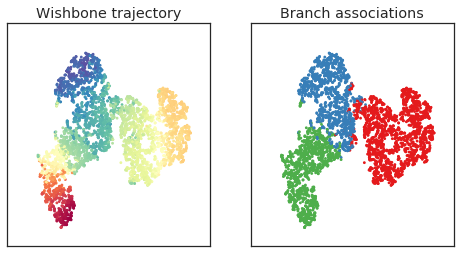

In [23]:
fig, ax = wb.plot_wishbone_on_tsne()

Gene expression trends along the Wishbone trajectory can be visualized using the `plot_marker_trajectory` function. This function also returns the smoothed trends along with the matplotlib fig, ax handler objects.

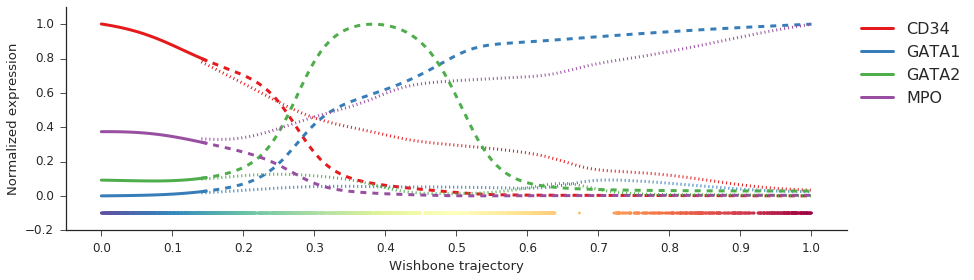

In [24]:
vals, fig, ax = wb.plot_marker_trajectory(['CD34', 'GATA1', 'GATA2', 'MPO']);

The marker trends can be visualized as heatmaps in a given trajectory range using the following functions

(<matplotlib.figure.Figure at 0x10efb1278>,
 <matplotlib.axes._subplots.AxesSubplot at 0x113154208>)

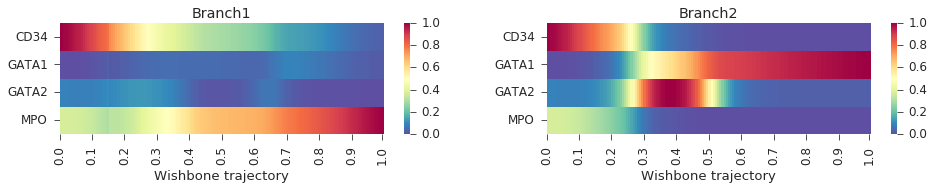

In [25]:
wb.plot_marker_heatmap(vals)

(<matplotlib.figure.Figure at 0x10efd4828>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10e9c6438>)

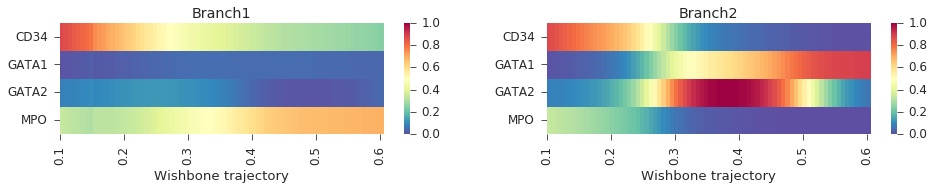

In [26]:
wb.plot_marker_heatmap(vals, trajectory_range=[0.1, 0.6])

The change in marker trends along the trajectory or derivatives can be visualized using these functions

(<matplotlib.figure.Figure at 0x10e9a5c50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11b1699e8>)

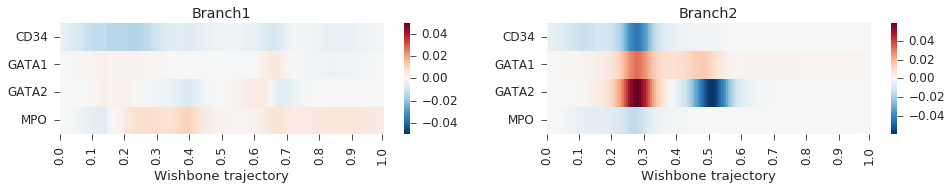

In [27]:
wb.plot_derivatives(vals)

(<matplotlib.figure.Figure at 0x11a38ee10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11a477630>)

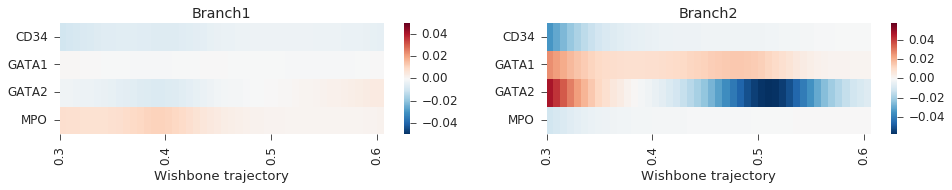

In [28]:
wb.plot_derivatives(vals, trajectory_range=[0.3, 0.6])

Similar to `SCData` objects, `Wishbone` objects can also be saved and loaded using `save` and `load` functions.